In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import zarr
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
from geopandas import GeoDataFrame
import numpy as np
import warnings
import geopy.distance
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# Load the functions
import sys
sys.path.insert(1, '../src')
from preprocessing import*
from random_forest_functions import*
from model_evaluation import*
from spatial_functions import*

# NARR Spatial Data Processing Notebook

The North American Regional Reanalysis (NARR) dataset was used to add spatial data to the model for each watershed. The NARR data had four variables that were used, total precipitation (apcp: $kg/m^2$), snow melt (snom: $kg/m^2$), 0-200 cm Soil moisture content (soilm: $kg/m^2$), and surface runoff (non-infiltrating) (ssrun: $kg/m^2$). One value for each of the four variables was recorded every three hours for every cell in the NARR gridded dataset. The cell size for the gridded NARR data is 32km by 32km, and the area of the 17 watersheds ranges from 91-27285 $km^2$. Since the NARR data was at a relatively low resolution compared to the area of the watersheds, a weighted average of NARR cells for the watershed was used for the spatial variable time series. The weights were determined by evaluating how much of a NARR cell was contained within a watershed. The values of acpc, snom, soilm, and ssrun that were associated with cells completely contained within the watershed were multiplied by 1, and the values associated with cells that were only partially included in the watershed were multiplied by the percent of the area of the cell that was captured by the watershed. To try and extract a better signal between changes in spatial data and flow data for the largest watersheds the distance of NARR cells from the gauge location was also evaluated. This was done by dividing the cells in a watershed into quartiles and taking the weighted average of each quartile.  

### Feature Engineering 

A small discussion on feature engineering has been included at the end of this notebook, since most feature engineering would be achieved through different forms of spatial data processing.  

In [2]:
# Connect to BLOB storage using a shared access signature, and wrap in a memory cache
sas_token = '?sv=2019-10-10&ss=bfqt&srt=sco&sp=rwdlacupx&se=2020-07-02T06:29:39Z&st=2020-05-22T22:29:39Z&spr=https,http&sig=pLsx0Afa18wA6Z9%2BL0YAmHkwYP3FS4ppocKRfKjC1Bo%3D'

blob_store = zarr.ABSStore(
    'narr',
    prefix='NARR.zarr',
    account_name='floodforecasting',
    blob_service_kwargs=dict(sas_token=sas_token)
)
store = zarr.LRUStoreCache(blob_store, max_size=2**28)

To determine how to slice the data by the `x` and `y` coordinates I used the `lat` and `lon` columns of the DataSet 

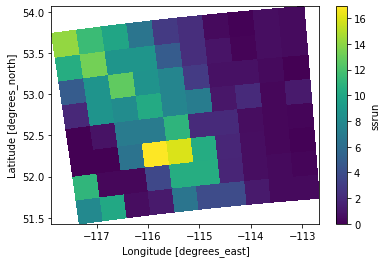

In [3]:
# open the xarray DataSet and index into a DataArray to look at the data
ds = xr.open_zarr(store)
da = ds['ssrun']
data = da.sel(time=slice('2004-01-01T00:00', '2004-02-01T00:00'), 
              y=slice(4836987, 5064228), 
              x=slice(4934376, 5226543)).sum(dim='time')
data.plot(y='lat', x='lon')

The above grid was created strictly to use for converting the `x` and `y` coordinates of each cell into a polygon for clipping the watersheds. To do so the DataArray of summed values over time was converted into a pandas dataframe. Then using the `lat` and `lon` values for each cell, a geometry for each cell was created and all the geometries were combined into a single geopandas object. Each row in the geopandas object was a point geometry, which was then transformed into a polygon object. This was done with multiple geopandas functions, and the inputs for those functions were determined visually by plotting. Plotting all of the polygon objects generated from the points creates the grid below. Due to the projection the grid is not perfectly aligned, but it is within an acceptable level of error for getting relative proportions of each cell for clipping watersheds. 

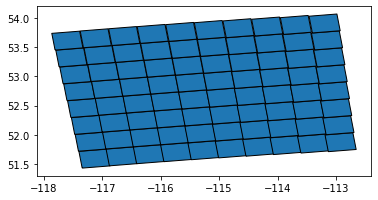

In [4]:
grid = create_ploygon_grid(data)
grid.plot(edgecolor='black')

In [2]:
stations = gpd.read_file('../data/Shapefiles/Hydrometric_Stations_2020_04_28.shp').to_crs("epsg:4326")
watersheds = gpd.read_file('../data/Shapefiles/WGS_watersheds.shp')

The plot below is an overview of all the watersheds, gauges and the raster grid the was created and clipped.

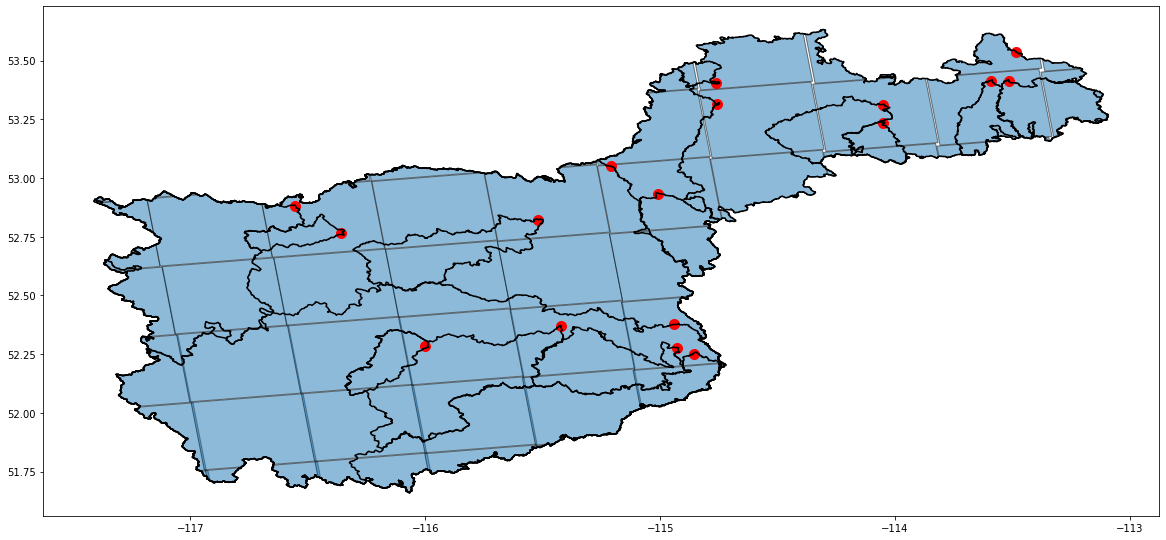

In [6]:
fig, ax = plt.subplots(1, figsize=(20, 20))
base1 = gpd.clip(grid, watersheds).plot(ax=ax, alpha=0.5, edgecolor='black')
base2 = watersheds.boundary.plot(ax=base1, edgecolor='black')
stations.plot(ax=base2, marker='o', color='red', markersize=100);

The following two cells call a function that clips the NARR grid to a watershed, and also calculates the distance between each cell and the gauge location if there are more than 4 cells clipped to the watershed. It then groups the cells into 4 groups by distance, with the `q1` geodataframe being the closest 25% of cells, and the `q4` geodataframe being the furtherst 25% of cells. If the watershed has more than 4 cells, the dictionary that is generated will need to be indexed with either `['whole_shed']`, `['q1']`, `['q2']`, `['q3']`, or `['q4']` to get the proportions and cells for either the entire watershed, or one of the quaters of the watershed defined by distance. This dictionary is then used to generate the dataframe time series for a given watershed, or quartile of a watershed. The function also prints output indicating whether the shed has less than 4 cells contained within it and therefore distances aren't relevant.

In [7]:
# watersheds and stations are the shapefiles loaded as geodataframes
dict_05DE007 = get_cells_and_distances('05DE007', grid, watersheds, stations)

no distances, watershed to small


In [8]:
# watersheds and stations are the shapefiles loaded as geodataframes
dict_05DC001 = get_cells_and_distances('05DC001', grid, watersheds, stations)

index into dict for dataframe generation:
['whole_shed'], ['q1'], ['q2'], ['q3'], or ['q4']


The function below plots the cells in a watershed coloured by their distances.

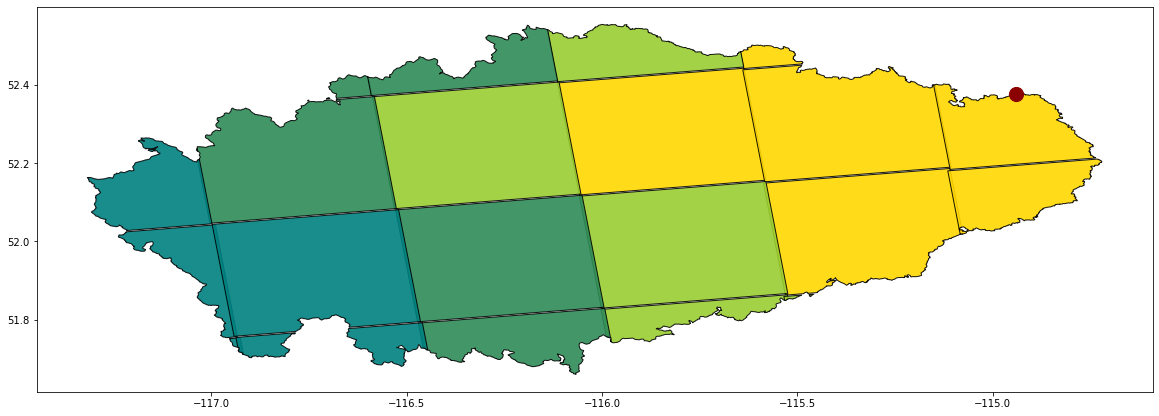

In [10]:
plot_distance('05DC001', dict_05DC001, stations)

index into dict for dataframe generation:
['whole_shed'], ['q1'], ['q2'], ['q3'], or ['q4']


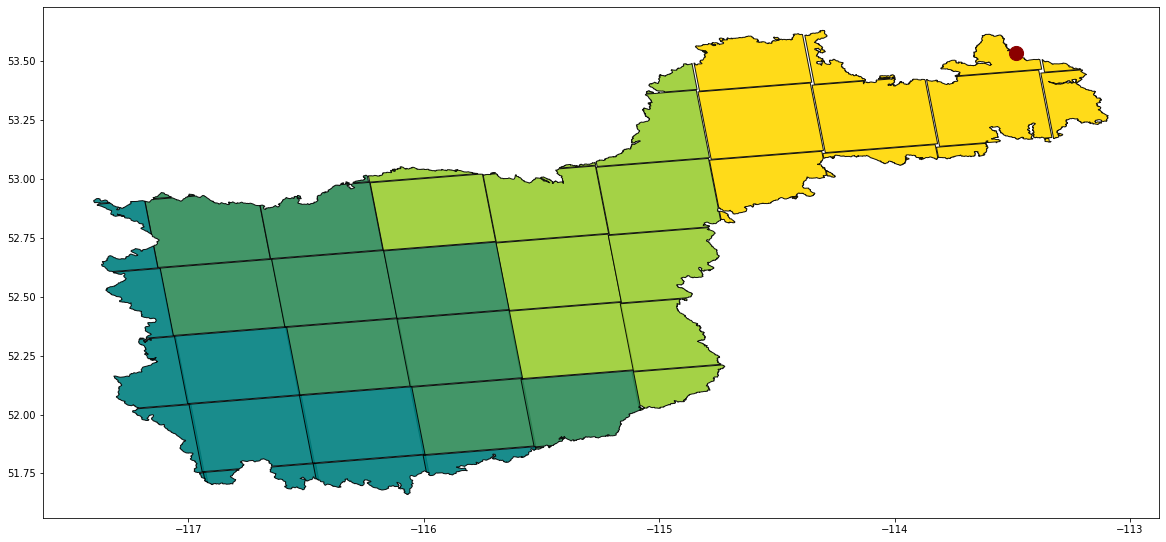

In [11]:
plot_distance('05DF001', get_cells_and_distances('05DF001', grid, watersheds, stations), stations)

The function below takes the clipping dictionary and uses that to index into the DataSet and generates a pandas dataframe object that can then easily be converted to a `csv`. 

In [13]:
df = get_NARR_dataframe(ds, dict_05DE007, time_start='1996-03-01T00:00', time_end='1996-03-01T06:00')
df

,time,apcp,snom,soilm,ssrun
0,1996-03-01 00:00:00,0.035000,0.0,459.461731,0.0
1,1996-03-01 03:00:00,0.061643,0.0,459.458008,0.0
2,1996-03-01 06:00:00,0.022313,0.0,459.455505,0.0


In [14]:
q4_df = get_NARR_dataframe(ds, dict_05DC001['q4'], time_start='1996-03-01T00:00', time_end='1996-03-01T06:00')
q4_df

,time,apcp,snom,soilm,ssrun
0,1996-03-01 00:00:00,0.000000,0.0,763.923401,0.0
1,1996-03-01 03:00:00,0.003206,0.0,763.919617,0.0
2,1996-03-01 06:00:00,0.002938,0.0,763.917175,0.0


# Feature Engineering 

The greatest challenge in this project was extracting features from spatial data that had a strong relationship with the flow data. Sequential improvements were made by taking the weighted average for the watershed based on proportions, and considering the distance of each measurement from the gauge. 

SNODAS and CaPA data were also considered. SNODAS data was presented in 12 hour increments and CaPA data was collected in 6 hour increments. The long intervals meant using the data alone likley would not have improved model performace for predicting hourly flow, however combining this data with the NARR data could lead to an improvement in NARR data quality.  This was not achieved due to time constraints, but is recommended for future work.

Another consideration for feature engineering would be to combine a Digital Elevation Model (DEM) with the NARR data as another way to evaluate distance. This is suggested because distance between NARR cells and the gauge is calculated directly, and the boundaries of the watershed are not considered. Grouping by elevation allows the morphology and topography of the watershed to be considered. Therfore, the lag between events such as rain fall, and change in flow can be more accuratley captured. 

A final thought for feature engineering is that it was diffcult to extract a strong feature for all watersheds across the study area because there was a large variation in watershed area and topgraphy. The lags for spatial features across largest watershed of 27285 $km^2$ would be significantly different for lags of spatial features across a watershed that is 91 $km^2$. Furthermore, even though some watersheds were a similar size, their geographic location meant that the influence of variables differed. For example, small watersheds close to the Rocky Mountains likley have streams with steep gradients, which means a short lag time between precipitation and change in flow, and they are also likley more influenced by snow melt. In contrast the small watersheds close to Edmonton are in the plains, therefore they likley have a lower stream gradient and the influence of variables like snow melt are less significant. To address this we tried to explore a small range of varrying watersheds to extract features, but in conclusion it is likley that a good predictor would need to be tuned to each watershed.